# CNN model
This notebook trains the CNN model.

**Trained on**: SemEval (2019)
**Tested on**: Waseem and Hovy (2016)

First we need to install the required packages.

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

# Mount drive for loading the data
drive.mount('/content/drive')

import sys
sys.path.append("drive/MyDrive/Colab Notebooks")

import tensorflow
from cnn import CNN
from reader import Reader
from sklearn.metrics import classification_report, confusion_matrix 
import numpy as np
from tensorflow.keras.utils import to_categorical
import html
from keras.layers import TextVectorization
import tensorflow_probability
import pickle
from keras import models

FILENAME = "drive/MyDrive/Colab Notebooks/data/twitter_data.pkl"
TEMPERATURE = 2.216935634613037
NUM_CLASSES = 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read and split the dataset

In [ ]:
reader = Reader(filename=FILENAME)
X, y = reader.load()

mapping = {'racism': 1,'sexism': 1, 'none': 0}
y = [mapping[b] for b in y]

X_train, X_val, X_test, y_train, y_val, y_test = reader.split_with_validation(X, y)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_CLASSES)

## Load the model

In [ ]:
model = models.load_model('drive/MyDrive/Colab Notebooks/output/cnn-semeval')

## Predict





In [ ]:
model_predictions = model.predict(X_test)
pred_divisions = tensorflow.math.divide(model_predictions, TEMPERATURE)

predicted_classes = np.argmax(model_predictions, axis=1)
actual_classes = np.argmax(y_test, axis=1)

print(confusion_matrix(actual_classes, predicted_classes))
print(classification_report(actual_classes, predicted_classes))

[[904 200]
 [359 146]]
              precision    recall  f1-score   support

           0       0.72      0.82      0.76      1104
           1       0.42      0.29      0.34       505

    accuracy                           0.65      1609
   macro avg       0.57      0.55      0.55      1609
weighted avg       0.62      0.65      0.63      1609



In [ ]:
def to_predictions(predictions, labels):
    predicted_classes = np.argmax(predictions, 1)
    return list(map(lambda predicted_values, predicted_class, actual_class:
                    {'predicted_class': class_name(predicted_class),
                     'actual_class': class_name(actual_class),
                     'predicted_value': predicted_values[predicted_class],
                     'text': None},
                    predictions, predicted_classes, labels))

def class_name(index):
    if index == 0:
        return "None"
    elif index == 1:
        return "Hate"


## Export predictions

In [ ]:
# Run Softmax function on the logits to get class probabilities
calibrated_predictions_all = tensorflow.nn.softmax(pred_divisions).numpy()
calibrated_predictions = np.argmax(calibrated_predictions_all, axis=1)
model_actual_classes = np.argmax(y_test, axis=1)

In [ ]:
calibrated_predictions_info = to_predictions(calibrated_predictions_all, model_actual_classes)
pickle.dump(calibrated_predictions_info, open("drive/MyDrive/Colab Notebooks/output/cnn-semeval-waseem.p", "wb"))

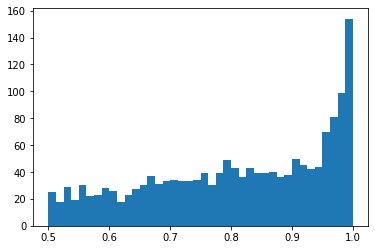

In [ ]:
softmax_non_calibrated = tensorflow.nn.softmax(model_predictions).numpy()
probs = np.max(softmax_non_calibrated, axis=1)
import matplotlib.pyplot as plt
plt.hist(probs, bins=40)
plt.show()

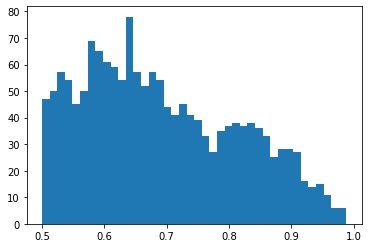

In [ ]:
probs = np.max(calibrated_predictions_all, axis=1)
import matplotlib.pyplot as plt
plt.hist(probs, bins=40)
plt.show()